In [13]:
from google.colab import files

uploaded = files.upload()  # Choose the file clean_telco.csv


Saving clean_telco.csv to clean_telco.csv


In [14]:
import pandas as pd

# Make sure the name matches exactly
df = pd.read_csv('clean_telco.csv')

# Check rows and columns
print(df.shape)    # Should show ~7043 rows
df.head()

(7032, 22)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_float
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,29.85
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,1889.50
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,108.15
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1840.75
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,151.65


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customerID          7032 non-null   object 
 1   gender              7032 non-null   object 
 2   SeniorCitizen       7032 non-null   int64  
 3   Partner             7032 non-null   object 
 4   Dependents          7032 non-null   object 
 5   tenure              7032 non-null   int64  
 6   PhoneService        7032 non-null   object 
 7   MultipleLines       7032 non-null   object 
 8   InternetService     7032 non-null   object 
 9   OnlineSecurity      7032 non-null   object 
 10  OnlineBackup        7032 non-null   object 
 11  DeviceProtection    7032 non-null   object 
 12  TechSupport         7032 non-null   object 
 13  StreamingTV         7032 non-null   object 
 14  StreamingMovies     7032 non-null   object 
 15  Contract            7032 non-null   object 
 16  Paperl

In [16]:
df['Churn'].value_counts()

,count
Churn,
No,5163
Yes,1869


In [17]:
# Drop customerID (not needed for modeling)
df.drop('customerID', axis=1, inplace=True)


In [18]:
# If TotalCharges is still object, convert
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])


In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])


In [20]:
X = df.drop('Churn', axis=1)
y = df['Churn']


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7910447761194029
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.65      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407



In [23]:
!pip install imbalanced-learn


In [24]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check the new class distribution
from collections import Counter
print("Original y_train distribution:", Counter(y_train))
print("Resampled y_train distribution:", Counter(y_train_res))


Original y_train distribution: Counter({0: 4130, 1: 1495})
Resampled y_train distribution: Counter({1: 4130, 0: 4130})


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Random Forest
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_res, y_train_res)

# Predict on original test set
y_pred_smote = rf_smote.predict(X_test)

# Evaluation
print("Accuracy after SMOTE:", accuracy_score(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))


Accuracy after SMOTE: 0.7611940298507462
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1033
           1       0.55      0.55      0.55       374

    accuracy                           0.76      1407
   macro avg       0.69      0.69      0.69      1407
weighted avg       0.76      0.76      0.76      1407



In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


In [27]:
param_grid = {
    'n_estimators': [100, 200],        # Number of trees
    'max_depth': [10, 20],             # Maximum depth of tree
    'min_samples_split': [2, 5],       # Minimum samples to split a node
    'min_samples_leaf': [1, 2],        # Minimum samples at a leaf node
    'max_features': ['sqrt'],           # Keep it simple
    'bootstrap': [True]                 # Use bootstrap
}


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                  # 3-fold cross-validation
    n_jobs=-1,             # Use all cores
    verbose=2,
    scoring='f1'           # Optimize F1-score for churn
)


In [29]:
grid_search.fit(X_train_res, y_train_res)
best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
print("Accuracy after fast tuning:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Accuracy after fast tuning: 0.7611940298507462
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1033
           1       0.54      0.66      0.60       374

    accuracy                           0.76      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.76      0.77      1407



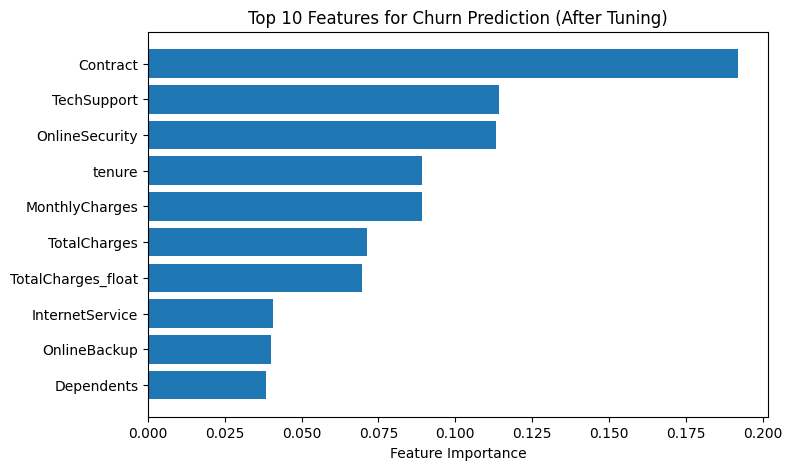

In [30]:
import matplotlib.pyplot as plt
import numpy as np

importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Features for Churn Prediction (After Tuning)")
plt.show()


In [31]:
# Add model predictions to CSV (optional)
df['Churn_Predicted'] = best_rf.predict(X)
df.to_csv("telco_dashboard.csv", index=False)


In [32]:
from google.colab import files

files.download("telco_dashboard.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>